<a href="https://colab.research.google.com/github/dayogh/portfolio/blob/main/Student_Performance_prediction__6_FEATURES_IN_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
sns.set()
from datetime import datetime as dt
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
cv = KFold(n_splits=10, random_state=0, shuffle= True)
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.linear_model import LogisticRegression as LGR, Lasso

from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE,SelectFromModel
from sklearn import metrics
#classifier_pipeline = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=10))

# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
link = '/content/drive/MyDrive/Thesis_Data/OULA/'
studentInfo = pd.read_csv(link + 'studentInfo.csv')
courses = pd.read_csv(link + 'courses.csv')
assessments = pd.read_csv(link + 'assessments.csv')
studentAssessments = pd.read_csv(link + 'studentAssessment.csv')
studentVle=pd.read_csv(link+'studentVle.csv')
vle=pd.read_csv(link +'vle.csv')

# FEATURE ENGINEERING

ASSESSMENTS

In [ ]:
# Module grouped by assessment
exams=assessments[assessments["assessment_type"]=="Exam"]
others=assessments[assessments["assessment_type"]!="Exam"]
amounts=others.groupby(["code_module","code_presentation"]).count()["id_assessment"] 
amounts=amounts.reset_index()
amounts.head()



,code_module,code_presentation,id_assessment
0,AAA,2013J,5
1,AAA,2014J,5
2,BBB,2013B,11
3,BBB,2013J,11
4,BBB,2014B,11


these are the non exams data


In [ ]:
assessments['assessment_type'].unique()

array(['TMA', 'Exam', 'CMA'], dtype=object)

In [ ]:
#Function to determine whether a student passed a given assessment
def pass_fail(grade):
    if grade>=40:
        return True
    else:
        return False
#Creating the stud_ass dataframe to join infos about the assessment weights and their respective grades
stud_ass=pd.merge(studentAssessments,others,how="inner",on=["id_assessment"])
stud_ass["pass"]=stud_ass["score"].apply(pass_fail)
stud_ass["weighted_grade"]=stud_ass["score"]*stud_ass["weight"]/100

In [ ]:
#Final assessment average per student per module
avg_grade=stud_ass.groupby(["id_student","code_module","code_presentation"]).sum()["weighted_grade"].reset_index()
avg_grade.head()

,id_student,code_module,code_presentation,weighted_grade
0,6516,AAA,2014J,63.50
1,8462,DDD,2013J,34.90
2,8462,DDD,2014J,43.00
3,11391,AAA,2013J,82.40
4,23629,BBB,2013B,16.69


In [ ]:

#Pass rate per student per module

pass_rate=pd.merge((stud_ass[stud_ass["pass"]==True].groupby(["id_student","code_module","code_presentation"]).count()["pass"]).reset_index(),amounts,how="left",on=["code_module","code_presentation"])
pass_rate["pass_rate"]=pass_rate["pass"]/pass_rate["id_assessment"]
pass_rate.drop(["pass","id_assessment"], axis=1,inplace=True)
pass_rate.head()

,id_student,code_module,code_presentation,pass_rate
0,6516,AAA,2014J,1.000000
1,8462,DDD,2013J,0.500000
2,8462,DDD,2014J,0.666667
3,11391,AAA,2013J,1.000000
4,23629,BBB,2013B,0.363636


In [ ]:
#Final exam scores
stud_exams=pd.merge(studentAssessments,exams,how="inner",on=["id_assessment"])
stud_exams["exam_score"]=stud_exams["score"]
stud_exams.drop(["id_assessment","date_submitted","is_banked", "score","assessment_type","date","weight"],axis=1,inplace=True)
stud_exams.head()

,id_student,code_module,code_presentation,exam_score
0,558914,CCC,2014B,32.0
1,559706,CCC,2014B,78.0
2,559770,CCC,2014B,54.0
3,560114,CCC,2014B,64.0
4,560311,CCC,2014B,100.0


VLE (VIRTUAL LEARNING ENVIRONMENT)

In [ ]:
vle.head()

,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,NaN,NaN
1,546712,AAA,2013J,oucontent,NaN,NaN
2,546998,AAA,2013J,resource,NaN,NaN
3,546888,AAA,2013J,url,NaN,NaN
4,547035,AAA,2013J,resource,NaN,NaN


In [ ]:
# total number of missing reference weeks 
reference_weeks =len(vle[~vle['week_from'].isna()])
print ('{} availabe weeks  '.format(reference_weeks) )


1121 availabe weeks  


In [ ]:
studentVle.head()

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1


In [ ]:
#Here we can track the average time after the start of the course the student took to use the materials
#and the average amount of clicks per material
avg_per_site=studentVle.groupby(["id_student","id_site","code_module","code_presentation"]).mean().reset_index()
avg_per_site.head()


,id_student,id_site,code_module,code_presentation,date,sum_click
0,6516,877011,AAA,2014J,210.333333,3.833333
1,6516,877012,AAA,2014J,90.833333,2.310606
2,6516,877015,AAA,2014J,113.461538,2.000000
3,6516,877023,AAA,2014J,122.666667,2.000000
4,6516,877025,AAA,2014J,41.142857,4.333333


In [ ]:
#General average per student per module
avg_per_student=avg_per_site.groupby(["id_student","code_module","code_presentation"]).mean()[["date","sum_click"]].reset_index()
avg_per_student.head()

,id_student,code_module,code_presentation,date,sum_click
0,6516,AAA,2014J,105.292573,5.816135
1,8462,DDD,2013J,38.794704,1.734524
2,8462,DDD,2014J,10.000000,3.000000
3,11391,AAA,2013J,111.739069,4.231515
4,23629,BBB,2013B,33.409632,2.817316


# start tweaking from here

STUDENTINFO

In [ ]:
#Removing the cases where the student has withdrawn their registration to the module
studentInfo=studentInfo[studentInfo["final_result"]!="Withdrawn"]
studentInfo=studentInfo[["code_module","code_presentation","id_student","num_of_prev_attempts","final_result"]]
studentInfo.head()


,code_module,code_presentation,id_student,num_of_prev_attempts,final_result
0,AAA,2013J,11391,0,Pass
1,AAA,2013J,28400,0,Pass
3,AAA,2013J,31604,0,Pass
4,AAA,2013J,32885,0,Pass
5,AAA,2013J,38053,0,Pass


# Merging the important tables


In [ ]:
df_1=pd.merge(avg_grade,pass_rate,how="inner",on=["id_student","code_module","code_presentation"])
assessment_info=pd.merge(df_1, stud_exams, how="inner", on=["id_student","code_module","code_presentation"])
assessment_info.head()


,id_student,code_module,code_presentation,weighted_grade,pass_rate,exam_score
0,23698,CCC,2014J,69.97,1.000000,80.0
1,24213,DDD,2014B,78.40,1.000000,58.0
2,27116,CCC,2014J,92.02,1.000000,96.0
3,28046,DDD,2013J,49.90,0.833333,40.0
4,28787,CCC,2014J,11.98,0.375000,44.0


In [ ]:
df_2=pd.merge(studentInfo,assessment_info,how="inner",on=["id_student","code_module","code_presentation"])
final_df=pd.merge(df_2,avg_per_student,how="inner", on=["id_student","code_module","code_presentation"])
final_df.drop(["id_student","code_module","code_presentation"],axis=1,inplace=True)
final_df.head()
#The final dataframe only has information relevant to the problem


,num_of_prev_attempts,final_result,weighted_grade,pass_rate,exam_score,date,sum_click
0,0,Distinction,89.65,1.000,94.0,103.457907,2.706754
1,0,Pass,84.58,1.000,76.0,87.617265,1.539047
2,0,Pass,51.44,0.625,66.0,49.181286,1.562619
3,0,Pass,75.13,1.000,50.0,118.698642,2.189217
4,0,Distinction,93.22,1.000,98.0,75.791987,2.100617


# EDA (Exploratory Data Analysis)

In [ ]:
final_df.describe()

,num_of_prev_attempts,weighted_grade,pass_rate,exam_score,date,sum_click
count,4950.000000,4950.000000,4950.000000,4950.000000,4950.000000,4950.000000
mean,0.118586,66.280909,0.868616,65.604444,101.047138,2.016114
std,0.395313,21.221975,0.182934,20.564815,24.917830,0.722249
min,0.000000,1.120000,0.125000,0.000000,17.566546,1.000000
25%,0.000000,51.512500,0.769231,51.000000,84.681549,1.545160
50%,0.000000,69.760000,1.000000,67.000000,99.934672,1.802246
75%,0.000000,83.622500,1.000000,82.000000,116.635412,2.279943
max,5.000000,100.000000,1.000000,100.000000,237.035714,13.134308


In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4950 entries, 0 to 4949
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   num_of_prev_attempts  4950 non-null   int64  
 1   final_result          4950 non-null   object 
 2   weighted_grade        4950 non-null   float64
 3   pass_rate             4950 non-null   float64
 4   exam_score            4950 non-null   float64
 5   date                  4950 non-null   float64
 6   sum_click             4950 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 309.4+ KB


The fact that the goal feature is categorical makes it not possible for us to include it in a correlation matrix, but we can see a tendency of correlation between the grading features (weighted_grade, pass_rate and exam_score)¶


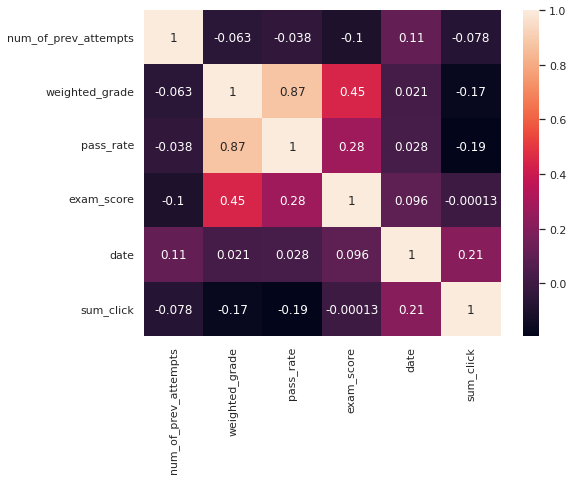

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(final_df.corr(),annot=True)


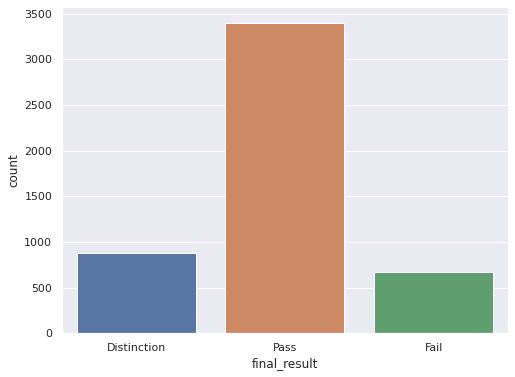

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(data=final_df, x="final_result")

With a "Pass" count much higher than the other labels, we must pay attention to the performance metrics fot the models and analyse the least represented cases more closely¶

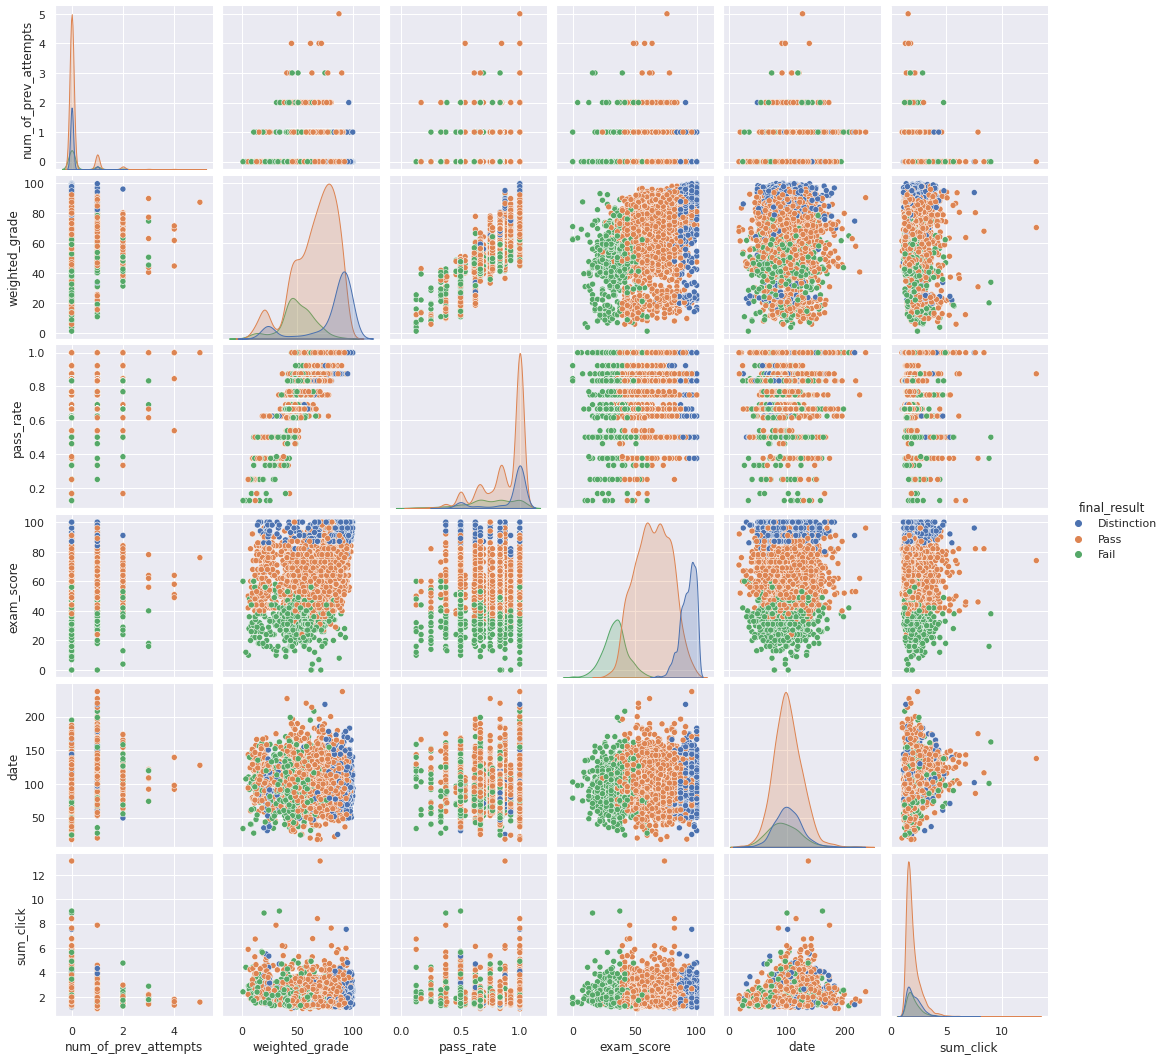

In [ ]:
sns.pairplot(final_df, hue='final_result')

On the pairplot we can detect two outliers: One with an average click number way above average and another one with a sole occurrence of an amount of previous attempts. In order to keep our data as consistent as possible, these cases will be removed¶

In [ ]:
final_df[final_df["sum_click"]>10]

,num_of_prev_attempts,final_result,weighted_grade,pass_rate,exam_score,date,sum_click
71,0,Pass,70.37,0.875,74.0,137.702513,13.134308


In [ ]:
final_df[final_df["num_of_prev_attempts"]>4]


,num_of_prev_attempts,final_result,weighted_grade,pass_rate,exam_score,date,sum_click
4908,5,Pass,87.3,1.0,76.0,127.634406,1.558457


In [ ]:
final_df=final_df[final_df["sum_click"]<=10]
final_df=final_df[final_df["num_of_prev_attempts"]<=4]
final_df.head()

,num_of_prev_attempts,final_result,weighted_grade,pass_rate,exam_score,date,sum_click
0,0,Distinction,89.65,1.000,94.0,103.457907,2.706754
1,0,Pass,84.58,1.000,76.0,87.617265,1.539047
2,0,Pass,51.44,0.625,66.0,49.181286,1.562619
3,0,Pass,75.13,1.000,50.0,118.698642,2.189217
4,0,Distinction,93.22,1.000,98.0,75.791987,2.100617


# Modeling


For the modeling step we will use the following techniques and models:

Cross validation paired with classification reports and confusion matrices to evaluate model performance
Logistic Regression
Linear Discriminant Analysis
Random Forest
Neural Network Classifier


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
X=final_df.drop("final_result", axis=1)
y=final_df["final_result"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Given the high correlation between weighted_grade and pass_rate the models will be fit to 3 types of inputs: One with both features and one with each one of them removed from the dataset

In [ ]:
#1 contains both, 2 just pass_rate e 3 just weighted_grade
X1_test=X_test
X1_train=X_train
X2_test=X_test.drop("weighted_grade",axis=1)
X2_train=X_train.drop("weighted_grade",axis=1)
X3_test=X_test.drop("pass_rate",axis=1)
X3_train=X_train.drop("pass_rate",axis=1)


In [ ]:
scaler1=MinMaxScaler()
scaler2=MinMaxScaler()
scaler3=MinMaxScaler()


In [ ]:
X1_train=scaler1.fit_transform(X1_train)
X1_test=scaler1.transform(X1_test)
X2_train=scaler2.fit_transform(X2_train)
X2_test=scaler2.transform(X2_test)
X3_train=scaler3.fit_transform(X3_train)
X3_test=scaler3.transform(X3_test)


LOGISTIC REGRESSION

In [ ]:
lr1=LogisticRegression(max_iter=10000)
lr1.fit(X1_train,y_train)
result_lr1=lr1.predict(X1_test)
print(confusion_matrix(y_test,result_lr1))
print("\n")
print(classification_report(y_test,result_lr1))

[[186   0  55]
 [  0 135  77]
 [ 38  25 969]]


              precision    recall  f1-score   support

 Distinction       0.83      0.77      0.80       241
        Fail       0.84      0.64      0.73       212
        Pass       0.88      0.94      0.91      1032

    accuracy                           0.87      1485
   macro avg       0.85      0.78      0.81      1485
weighted avg       0.87      0.87      0.86      1485



In [ ]:
lr2=LogisticRegression(max_iter=10000)
lr2.fit(X2_train,y_train)
result_lr2=lr2.predict(X2_test)
print(confusion_matrix(y_test,result_lr2))
print("\n")
print(classification_report(y_test,result_lr2))


[[185   0  56]
 [  0 137  75]
 [ 44  23 965]]


              precision    recall  f1-score   support

 Distinction       0.81      0.77      0.79       241
        Fail       0.86      0.65      0.74       212
        Pass       0.88      0.94      0.91      1032

    accuracy                           0.87      1485
   macro avg       0.85      0.78      0.81      1485
weighted avg       0.87      0.87      0.86      1485



In [ ]:
lr3=LogisticRegression(max_iter=10000)
lr3.fit(X3_train,y_train)
result_lr3=lr3.predict(X3_test)
print(confusion_matrix(y_test,result_lr3))
print("\n")
print(classification_report(y_test,result_lr3))

[[184   0  57]
 [  0 132  80]
 [ 41  25 966]]


              precision    recall  f1-score   support

 Distinction       0.82      0.76      0.79       241
        Fail       0.84      0.62      0.72       212
        Pass       0.88      0.94      0.90      1032

    accuracy                           0.86      1485
   macro avg       0.84      0.77      0.80      1485
weighted avg       0.86      0.86      0.86      1485



# MODEL 2: LDA

In [ ]:
lda1=LinearDiscriminantAnalysis()
lda1.fit_transform(X1_train,y_train)
result_lda1=lda1.predict(X1_test)
print(confusion_matrix(y_test,result_lda1))
print("\n")
print(classification_report(y_test,result_lda1))

[[202   0  39]
 [  0 169  43]
 [ 69  39 924]]


              precision    recall  f1-score   support

 Distinction       0.75      0.84      0.79       241
        Fail       0.81      0.80      0.80       212
        Pass       0.92      0.90      0.91      1032

    accuracy                           0.87      1485
   macro avg       0.83      0.84      0.83      1485
weighted avg       0.88      0.87      0.87      1485



In [ ]:
lda2=LinearDiscriminantAnalysis()
lda2.fit_transform(X2_train,y_train)
result_lda2=lda2.predict(X2_test)
print(confusion_matrix(y_test,result_lda2))
print("\n")
print(classification_report(y_test,result_lda2))


[[209   0  32]
 [  0 172  40]
 [ 74  40 918]]


              precision    recall  f1-score   support

 Distinction       0.74      0.87      0.80       241
        Fail       0.81      0.81      0.81       212
        Pass       0.93      0.89      0.91      1032

    accuracy                           0.87      1485
   macro avg       0.83      0.86      0.84      1485
weighted avg       0.88      0.87      0.88      1485



In [ ]:
lda3=LinearDiscriminantAnalysis()
lda3.fit_transform(X3_train,y_train)
result_lda3=lda3.predict(X3_test)
print(confusion_matrix(y_test,result_lda3))
print("\n")
print(classification_report(y_test,result_lda3))

[[201   0  40]
 [  0 173  39]
 [ 77  48 907]]


              precision    recall  f1-score   support

 Distinction       0.72      0.83      0.77       241
        Fail       0.78      0.82      0.80       212
        Pass       0.92      0.88      0.90      1032

    accuracy                           0.86      1485
   macro avg       0.81      0.84      0.82      1485
weighted avg       0.87      0.86      0.86      1485



# RANDOM FOREST

In [ ]:
rf1=RandomForestClassifier(n_estimators=300)
rf1.fit(X1_train,y_train)
result_rf1=rf1.predict(X1_test)
print(confusion_matrix(y_test,result_rf1))
print("\n")
print(classification_report(y_test,result_rf1))


[[200   0  41]
 [  0 163  49]
 [ 35  29 968]]


              precision    recall  f1-score   support

 Distinction       0.85      0.83      0.84       241
        Fail       0.85      0.77      0.81       212
        Pass       0.91      0.94      0.93      1032

    accuracy                           0.90      1485
   macro avg       0.87      0.85      0.86      1485
weighted avg       0.90      0.90      0.90      1485



In [ ]:
rf2=RandomForestClassifier(n_estimators=300)
rf2.fit(X2_train,y_train)
result_rf2=rf2.predict(X2_test)
print(confusion_matrix(y_test,result_rf2))
print("\n")
print(classification_report(y_test,result_rf2))

[[205   0  36]
 [  0 164  48]
 [ 62  29 941]]


              precision    recall  f1-score   support

 Distinction       0.77      0.85      0.81       241
        Fail       0.85      0.77      0.81       212
        Pass       0.92      0.91      0.91      1032

    accuracy                           0.88      1485
   macro avg       0.85      0.85      0.84      1485
weighted avg       0.88      0.88      0.88      1485



In [ ]:
rf3=RandomForestClassifier(n_estimators=300)
rf3.fit(X3_train,y_train)
result_rf3=rf3.predict(X3_test)
print(confusion_matrix(y_test,result_rf3))
print("\n")
print(classification_report(y_test,result_rf3))


[[203   0  38]
 [  0 164  48]
 [ 47  30 955]]


              precision    recall  f1-score   support

 Distinction       0.81      0.84      0.83       241
        Fail       0.85      0.77      0.81       212
        Pass       0.92      0.93      0.92      1032

    accuracy                           0.89      1485
   macro avg       0.86      0.85      0.85      1485
weighted avg       0.89      0.89      0.89      1485



# MODEL 4: NEURAL NETWORK

In [ ]:
model1=Sequential()

model1.add(Dense(6, activation="relu"))
model1.add(Dropout(0.5))
model1.add(Dense(3, activation="relu"))
model1.add(Dense(1, activation="sigmoid"))

model1.compile(loss="binary_crossentropy", optimizer="adam", metrics="accuracy")

In [ ]:
model2=Sequential()

model2.add(Dense(5, activation="relu"))
model2.add(Dropout(0.5))
model2.add(Dense(3, activation="relu"))
model2.add(Dense(1, activation="sigmoid"))

model2.compile(loss="binary_crossentropy", optimizer="adam", metrics="accuracy")

In [ ]:
model3=Sequential()

model3.add(Dense(5, activation="relu"))
model3.add(Dropout(0.5))
model3.add(Dense(3, activation="relu"))
model3.add(Dense(1, activation="sigmoid"))

model3.compile(loss="binary_crossentropy", optimizer="adam", metrics="accuracy")


In [ ]:
#For the neural network training, the outputs needed to be codified, and in order to avoid the ordinalization
#of the classes I chose to classify the distintion cases toghether with thw pass cases
def categories(cat):
    if cat=="Fail":
        return 0
    if cat=="Pass":
        return 1
    if cat=="Distinction":
        return 1
    
y_test=list(map(categories,y_test))
y_train=list(map(categories,y_train))


In [ ]:
y_train=np.asarray(y_train)
y_test=np.asarray(y_test)
early_stop=EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=25)

In [ ]:
history=model1.fit(x=X1_train, y=y_train, epochs=2000, validation_data=(X1_test,y_test),callbacks=[early_stop])


Epoch 1/2000
109/109 [==============================] - 1s 4ms/step - loss: 0.5495 - accuracy: 0.8640 - val_loss: 0.4747 - val_accuracy: 0.8572
Epoch 2/2000
109/109 [==============================] - 0s 2ms/step - loss: 0.4924 - accuracy: 0.8680 - val_loss: 0.4237 - val_accuracy: 0.8572
Epoch 3/2000
109/109 [==============================] - 0s 2ms/step - loss: 0.4617 - accuracy: 0.8680 - val_loss: 0.4053 - val_accuracy: 0.8572
Epoch 4/2000
109/109 [==============================] - 0s 2ms/step - loss: 0.4465 - accuracy: 0.8680 - val_loss: 0.3953 - val_accuracy: 0.8572
Epoch 5/2000
109/109 [==============================] - 0s 3ms/step - loss: 0.4228 - accuracy: 0.8680 - val_loss: 0.3874 - val_accuracy: 0.8572
Epoch 6/2000
109/109 [==============================] - 0s 2ms/step - loss: 0.4050 - accuracy: 0.8680 - val_loss: 0.3793 - val_accuracy: 0.8572
Epoch 7/2000
109/109 [==============================] - 0s 3ms/step - loss: 0.3933 - accuracy: 0.8680 - val_loss: 0.3723 - val_accuracy:

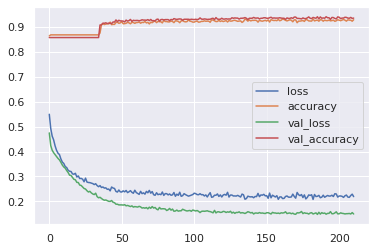

In [ ]:
losses=pd.DataFrame(model1.history.history)
losses.plot()


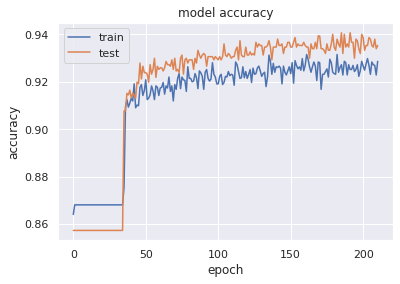

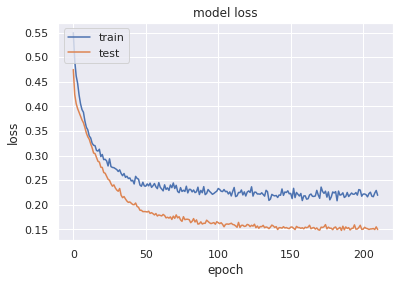

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# summarize the history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
model2.fit(x=X2_train, y=y_train, epochs=2000, validation_data=(X2_test,y_test),callbacks=[early_stop])

Epoch 1/2000
109/109 [==============================] - 1s 4ms/step - loss: 0.5982 - accuracy: 0.7537 - val_loss: 0.5285 - val_accuracy: 0.8572
Epoch 2/2000
109/109 [==============================] - 0s 2ms/step - loss: 0.4879 - accuracy: 0.8683 - val_loss: 0.4436 - val_accuracy: 0.8572
Epoch 3/2000
109/109 [==============================] - 0s 2ms/step - loss: 0.4277 - accuracy: 0.8680 - val_loss: 0.3994 - val_accuracy: 0.8572
Epoch 4/2000
109/109 [==============================] - 0s 2ms/step - loss: 0.3986 - accuracy: 0.8680 - val_loss: 0.3819 - val_accuracy: 0.8572
Epoch 5/2000
109/109 [==============================] - 0s 2ms/step - loss: 0.3709 - accuracy: 0.8680 - val_loss: 0.3782 - val_accuracy: 0.8572
Epoch 6/2000
109/109 [==============================] - 0s 2ms/step - loss: 0.3567 - accuracy: 0.8680 - val_loss: 0.3714 - val_accuracy: 0.8572
Epoch 7/2000
109/109 [==============================] - 0s 2ms/step - loss: 0.3470 - accuracy: 0.8680 - val_loss: 0.3634 - val_accuracy:

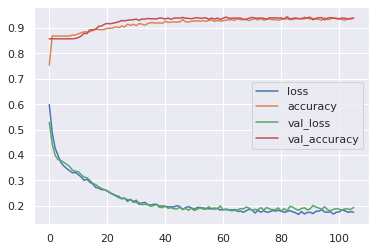

In [ ]:
losses=pd.DataFrame(model2.history.history)
losses.plot()
